In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv1D

<em>Preprocessing dataset<em></em>

In [ ]:
from scipy.io import arff
from sklearn.model_selection import train_test_split

train_data, train_meta = arff.loadarff('CharacterTrajectoriesTRAIN.arff')
test_data, test_meta = arff.loadarff('CharacterTrajectoriesTEST.arff')

train_inputs, train_labels = list(zip(*train_data))
test_inputs, test_labels = list(zip(*test_data))

# convert to np array
train_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in train_inputs])
test_inputs = np.array([ [ np.array(list(channel), dtype=float) for channel in input ]  for input in test_inputs])

train_labels = np.array(train_labels, dtype=int)
test_labels = np.array(test_labels, dtype=int)

# subtract 1 from labels to start indexing from 0
train_labels -= 1; test_labels -= 1
print("labels :  ", np.unique(train_labels))

train_inputs = np.nan_to_num(train_inputs)
test_inputs = np.nan_to_num(test_inputs)

# split train into train and validation
train_inputs, val_inputs, train_labels, val_labels, = train_test_split(train_inputs, train_labels, test_size=0.25, random_state=0)


train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)
val_labels_categorical = to_categorical(val_labels)

# train_inputs , train_labels, train_labels_categorical
# test_inputs , test_labels, test_labels_categorical
# val_inputs , val_labels, val_labels_categorical


In [3]:
num_classes = 20


class TimeSeriesModel1D(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        #Conv1
        self.add(Conv1D(96,kernel_size=2, input_shape=input_shape,activation= 'relu',padding="causal",kernel_initializer= 'he_normal'))
        #Conv2
        self.add(Conv1D(256,kernel_size=2,strides=1,activation= 'relu',padding="causal",kernel_initializer= 'he_normal'))
        #Conv3
        self.add(Conv1D(384,kernel_size=2,strides=1,activation= 'relu',padding="causal",kernel_initializer= 'he_normal',))
        #Conv4
        self.add(Conv1D(384,kernel_size=2,strides=1,activation= 'relu',padding="causal",kernel_initializer= 'he_normal'))
        #Conv5
        self.add(Conv1D(256,kernel_size=2,strides=1,activation= 'relu',padding="causal",kernel_initializer= 'he_normal'))

        self.add(Flatten())
        self.add(Dense(num_classes, activation= 'softmax'))
        self.compile(optimizer= tf.keras.optimizers.SGD( momentum=0.5, nesterov=True, learning_rate=0.02),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


#3 x 182
model = TimeSeriesModel1D((3,182),num_classes)

model.summary()
print('OK')

Model: "time_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 96)             35040     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 256)            49408     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 384)            196992    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 384)            295296    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3, 256)            196864    
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                153

<em>Training parameters and training process<em></em>

In [4]:
EPOCHS = 40
BATCH_SIZE = 30

model.fit(train_inputs, train_labels_categorical,
          epochs=EPOCHS,
          validation_data=(val_inputs,val_labels_categorical),
          verbose=1)


Epoch 1/40
34/34 [==============================] - 0s 11ms/step - loss: 1.5573 - accuracy: 0.5779 - val_loss: 1.2145 - val_accuracy: 0.6096
Epoch 2/40
34/34 [==============================] - 0s 6ms/step - loss: 0.4845 - accuracy: 0.8630 - val_loss: 0.3412 - val_accuracy: 0.9101
Epoch 3/40
34/34 [==============================] - 0s 5ms/step - loss: 0.2562 - accuracy: 0.9353 - val_loss: 0.1755 - val_accuracy: 0.9551

<em>Evaluation of class-wise accuracies<em></em>


In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predict = model.predict(test_inputs)
test_predict_labels = np.argmax(predict,axis=1)


matrix_confusion = confusion_matrix(test_labels,test_predict_labels)
print("Class-wise accuracies\n")
class_wise_accuracies = matrix_confusion.diagonal()/matrix_confusion.sum(axis=1)
for i in range(len(class_wise_accuracies)):
    print("Class " + str(i) + " accuracy: " + str(class_wise_accuracies[i]))

print("\nClassification_report\n")
target_names = []
for i in range(num_classes):
    target_names.append("Class " +str(i))
print(classification_report(test_labels, test_predict_labels, target_names=target_names))


Class-wise accuracies

Class 0 accuracy: 1.0
Class 1 accuracy: 1.0
Class 2 accuracy: 1.0
Class 3 accuracy: 1.0
Class 4 accuracy: 0.956989247311828
Class 5 accuracy: 1.0
Class 6 accuracy: 0.953125
Class 7 accuracy: 1.0
Class 8 accuracy: 0.9523809523809523
Class 9 accuracy: 0.9846153846153847
Class 10 accuracy: 0.9436619718309859
Class 11 accuracy: 0.9848484848484849
Class 12 accuracy: 1.0
Class 13 accuracy: 0.9666666666666667
Class 14 accuracy: 1.0
Class 15 accuracy: 0.9696969696969697
Class 16 accuracy: 1.0
Class 17 accuracy: 0.873015873015873
Class 18 accuracy: 1.0
Class 19 accuracy: 1.0

Classification_report

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99        86
     Class 1       1.00      1.00      1.00        71
     Class 2       1.00      1.00      1.00        71
     Class 3       0.96      1.00      0.98        79
     Class 4       1.00      0.96      0.98        93
     Class 5       1.00      1.00      1.00        69
 

<em>Getting class sample <em></em>

In [6]:
import random
# Getting sample per class
images_per_class=[]
for i in range(num_classes):
    if test_labels[i] == i:
        range_random=random.randint(1, 20)
        i=i+range_random
    images_per_class.append(test_inputs[i])

<em>Grad-CAM - Gradient Class Activation Map<em></em>

In [7]:
import tensorflow.keras.backend as K

def gradCAM(x):

    with tf.GradientTape() as tape:
        # Getting last convolution layer
        last_conv_layer = model.get_layer('conv1d_4')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        pooled_grads = K.mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    return heatmap

In [8]:
map = np.ones((1,3,182))
map[0] = test_inputs[0]
heatmap = gradCAM(map)
print(heatmap[0].shape)


(3,)


In [9]:
heatmaps_number = 31 #number of created heatmaps

heatmaps_of_images = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
heatmaps_number = heatmaps_number-1
corrcoef_pearsonr = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
corrcoef_spearmanr = [[0 for j in range(heatmaps_number)] for i in range(num_classes)]
# Adding first heatmaps
for i in range(num_classes):
    map = np.ones((1,3,182))
    map[0] = test_inputs[i]
    heatmaps_of_images[i][0]=gradCAM(map)

<em>Investigation of the significance of noise influence on heat maps></em>

In [10]:
import scipy.stats

def add_noise_to_image(image, mean = 0,var = 0.1):
    row,col= image.shape
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

mean = np.arange(0.0, 1.0, 1/len(corrcoef_pearsonr[0]))
print("I'm adding the gaussian noise to images changing mean")
for j in range(num_classes):
    noisy_image = np.ones_like(images_per_class[0])
    print("Class " + str(j) + " of " + str(num_classes-1) ,end="\r")
    for i in range(len(corrcoef_pearsonr[0])):

        noisy_image = add_noise_to_image(images_per_class[j],mean[i])
        map = np.ones((1,3,182))
        map[0] = noisy_image
        heatmaps_of_images[j][i+1] = gradCAM(map)

        corrcoef_pearsonr[j][i] = scipy.stats.pearsonr(np.reshape(heatmaps_of_images[j][0], [-1]), np.reshape(heatmaps_of_images[j][i+1], [-1]))[0]
        corrcoef_spearmanr[j][i] = scipy.stats.spearmanr(np.reshape(heatmaps_of_images[j][0], [-1]), np.reshape(heatmaps_of_images[j][i+1], [-1]))[0]

I'm adding the gaussian noise to images changing mean


<em>Statistic visualisation<em></em>

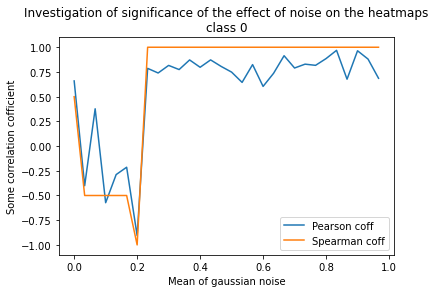

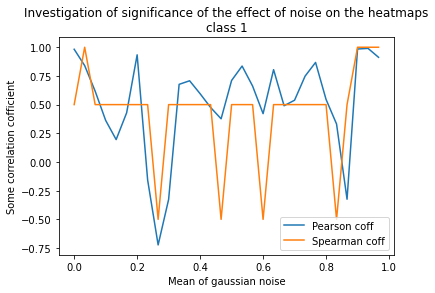

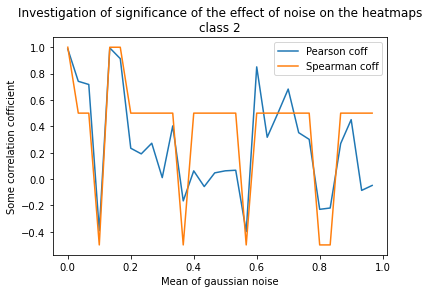

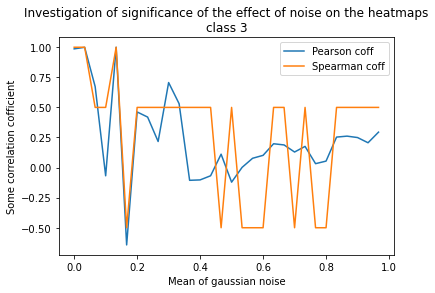

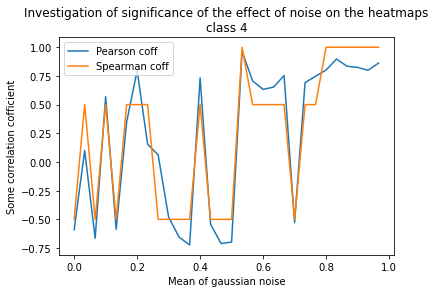

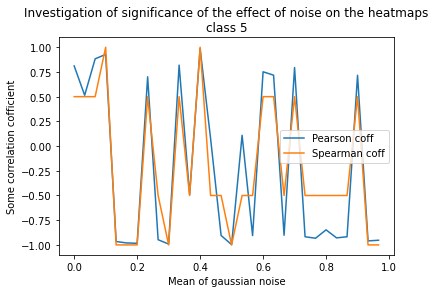

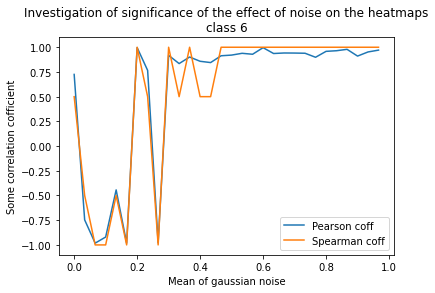

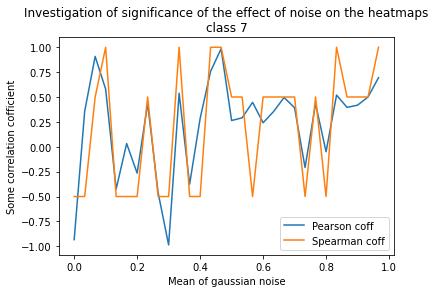

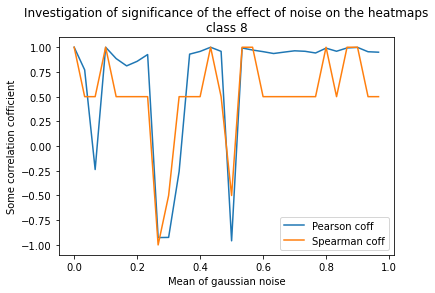

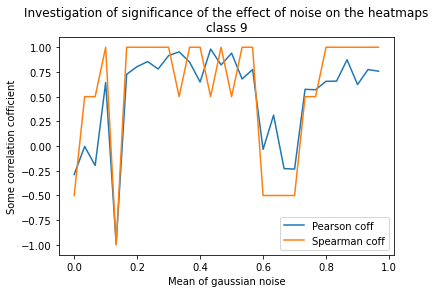

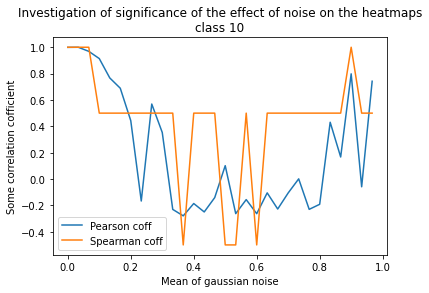

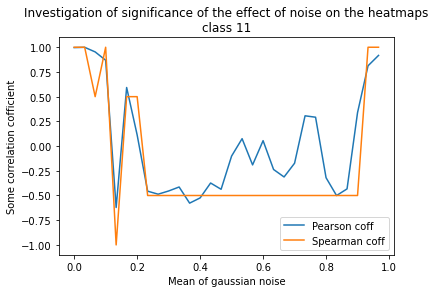

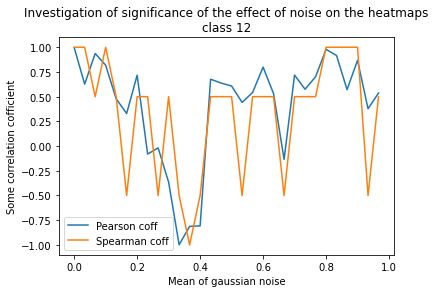

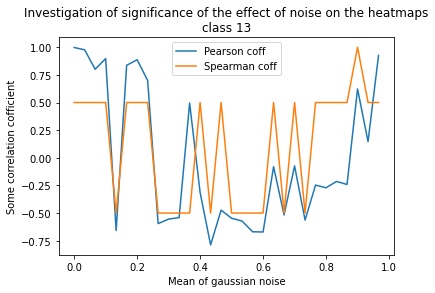

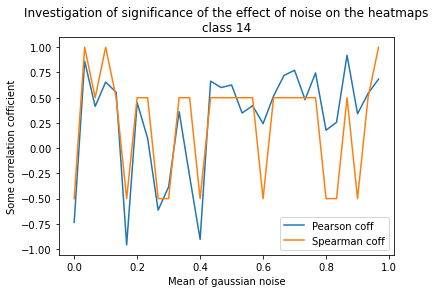

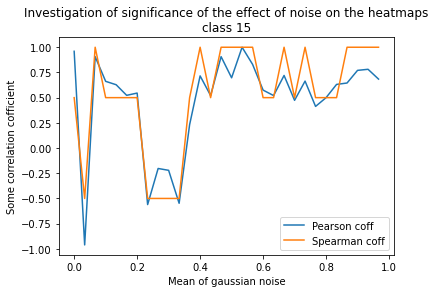

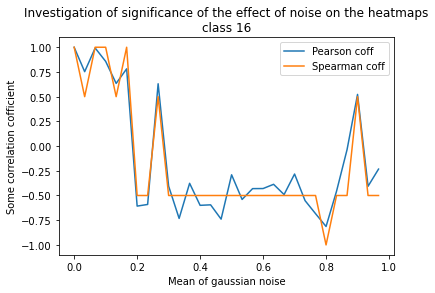

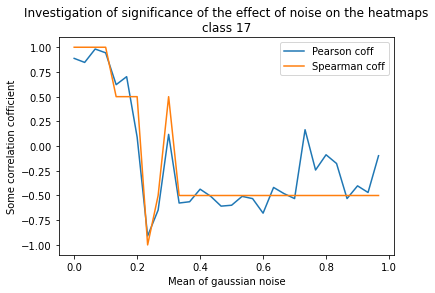

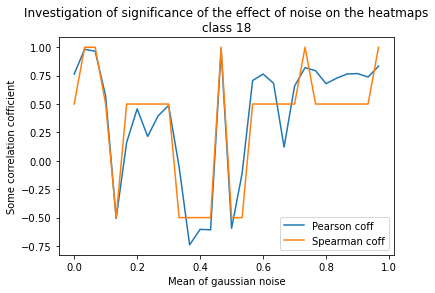

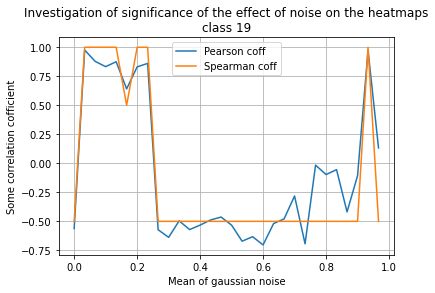

In [11]:

import matplotlib.pyplot as plt

def print_statistic(corrcoef_pearsonr,corrcoef_spearmanr,mean):
    horisontal = mean

    for i in range(len(corrcoef_pearsonr)):
        fig, ax = plt.subplots()
        ax.plot(horisontal,corrcoef_pearsonr[i],label='Pearson coff')
        ax.plot(horisontal,corrcoef_spearmanr[i],label='Spearman coff')
        ax.legend()
        ax.set(xlabel='Mean of gaussian noise', ylabel='Some correlation cofficient',
               title='Investigation of significance of the effect of noise on the heatmaps\nclass %d'%i)
    ax.grid()
    plt.show()

print_statistic(corrcoef_pearsonr,corrcoef_spearmanr,mean)


